# **Identificación de Imágenes Auténticas y Sintéticas : Abordando los Desafíos de las Imágenes Sintéticas en la Sociedad Actual**

**Contenido**
1. [Configuración del Entorno](#title1)
2. [Construcción del Conjunto de Datos](#title2)
3. [Creación del Modelo](#title3)

## Configuración del Entorno<a name="title1"></a>

In [3]:
import tensorflow as tf
print(tf.config.experimental.list_physical_devices("GPU"))
print(tf.__version__)
# Para limitar la memoria que usa la GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar TensorFlow para que solo utilice la GPU si es necesario
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Configuración de GPU completada")
    except RuntimeError as e:
        print(e)
# Verifica que la GPU está disponible
print("¿GPU está disponible?:", tf.config.list_physical_devices('GPU'))
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import gc
import tensorflow as tf
from keras import backend as K

# Limpiar la memoria del backend
K.clear_session()
# Forzar la recolección de basura
gc.collect()


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0
Configuración de GPU completada
¿GPU está disponible?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


105

In [4]:
# Limpiar la memoria del backend
K.clear_session()
# Forzar la recolección de basura
gc.collect()

105

In [5]:
#@title Importar todas las librerías de uso.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import glob
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, SpatialDropout2D
from tensorflow.keras.metrics import Accuracy, AUC, Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from sklearn import metrics
import matplotlib.image as mpmig
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import class_weight
from tensorflow.keras import regularizers

sns.set_theme()

## Construcción del Conjunto de Datos y Preprocesandolos<a name="title2"></a>

Fuente: https://www.kaggle.com/datasets/kaustubhdhote/human-faces-dataset & https://www.kaggle.com/datasets/hamzaboulahia/hardfakevsrealfaces/code

In [6]:
# Parámetros
batch_size = 32
img_height = 178
img_width = 178

# Directorios de datos
train_folder = './Data/Train'
test_folder = './Data/Test'

# Cargar datasets
train_dataset = image_dataset_from_directory(
    train_folder,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

validation_dataset = image_dataset_from_directory(
    train_folder,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_dataset = image_dataset_from_directory(
    test_folder,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Capturar class_names antes de prefetch
class_names = train_dataset.class_names
print("Clases:", class_names)

# Aplicar prefetch
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 9630 files belonging to 2 classes.
Using 7704 files for training.
Found 9630 files belonging to 2 classes.
Using 1926 files for validation.
Found 1289 files belonging to 2 classes.
Clases: ['Fake', 'Real']


In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.2, 0.2), 
    layers.RandomCrop(img_height, img_width) 
])

In [8]:
# Modelo base y arquitectura
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(1, activation='sigmoid')

# Modelo<a name="title3"></a>



In [11]:
#@title Construcción del modelo
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.3)(x)  # Dropout adicional
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Fine-tuning
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compilación del modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 178, 178, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 178, 178, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                           

In [12]:
# Callbacks para Early Stopping y Learning Rate Scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10 ** (epoch / 20))

# Entrenamiento del modelo
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=[early_stopping, lr_schedule]
)

Epoch 1/30
241/241 [==============================] - 159s 607ms/step - loss: 0.4415 - accuracy: 0.9045 - val_loss: 0.4210 - val_accuracy: 0.9226 - lr: 1.0000e-05
Epoch 2/30
241/241 [==============================] - 145s 602ms/step - loss: 0.2535 - accuracy: 0.9939 - val_loss: 0.2780 - val_accuracy: 0.9808 - lr: 1.1220e-05
Epoch 3/30
241/241 [==============================] - 144s 599ms/step - loss: 0.2472 - accuracy: 0.9947 - val_loss: 0.3848 - val_accuracy: 0.9382 - lr: 1.2589e-05
Epoch 4/30
241/241 [==============================] - 143s 595ms/step - loss: 0.2336 - accuracy: 0.9975 - val_loss: 0.3746 - val_accuracy: 0.9403 - lr: 1.4125e-05
Epoch 5/30
241/241 [==============================] - 144s 596ms/step - loss: 0.2276 - accuracy: 0.9971 - val_loss: 0.3228 - val_accuracy: 0.9600 - lr: 1.5849e-05
Epoch 6/30
241/241 [==============================] - 145s 601ms/step - loss: 0.2191 - accuracy: 0.9979 - val_loss: 0.2129 - val_accuracy: 1.0000 - lr: 1.7783e-05
Epoch 7/30
241/241 [==

41/41 [==============================] - 1s 25ms/step - loss: 7.8784 - accuracy: 0.4569
Pérdida en el conjunto de test: 7.87844705581665
Precisión en el conjunto de test: 0.4569433629512787
41/41 [==============================] - 2s 25ms/step


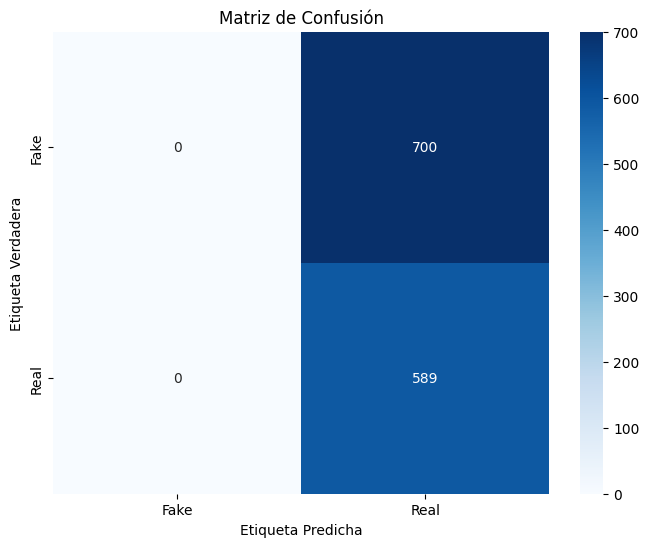


Reporte de Clasificación:
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00       700
        Real       0.46      1.00      0.63       589

    accuracy                           0.46      1289
   macro avg       0.23      0.50      0.31      1289
weighted avg       0.21      0.46      0.29      1289

Precisión Global: 0.4569433669511249


c:\Users\isidr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\isidr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\isidr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [9]:
#@title Metricas

# Evaluación
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Pérdida en el conjunto de test: {test_loss}")
print(f"Precisión en el conjunto de test: {test_accuracy}")

# Predicciones
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = model.predict(test_dataset)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

# Matriz de Confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()

# Reporte de Clasificación
print("\nReporte de Clasificación:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Precisión Global
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Precisión Global: {accuracy}")

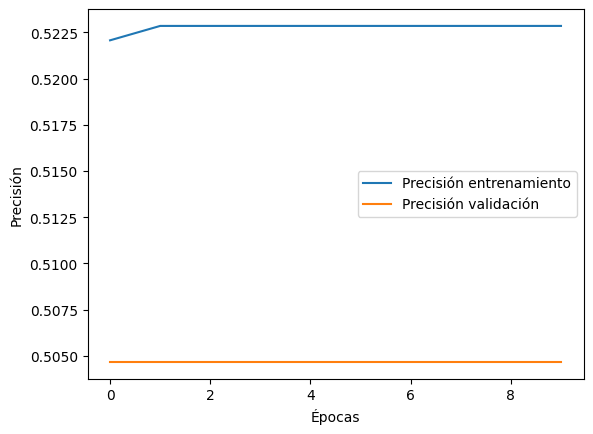

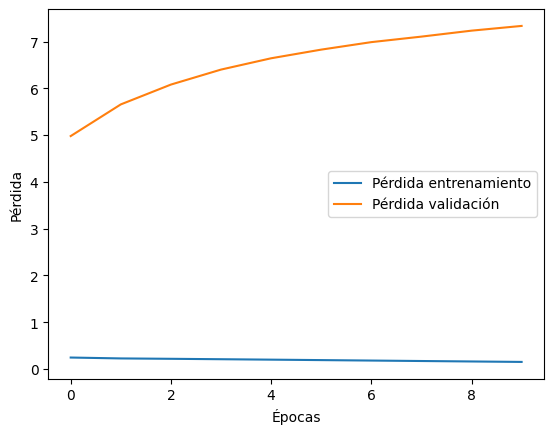

In [10]:
# Visualizar los resultados de entrenamiento
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()